In [98]:
#Import packages
import pandas as pd
pd.set_option('mode.chained_assignment', None)  # Suppress SettingWithCopyWarning
import numpy as np

from functions import plot_cpt_data_NW_site_all
import matplotlib.pyplot as plt

In [99]:
######################## Define the text size of each plot globally ###########
SMALL_SIZE = 10
BIGGER_SIZE = 10

plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=SMALL_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=SMALL_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title

plt.rcParams["font.family"] = "Times New Roman"
######################## Define the text size of each plot globally ###########

In [100]:
file_path = r"..\\data\BBC\Sand\CPT\OYSC35.xlsx"

#select desired columns as for the model training
selected_columns_x = ['Depth (m)','qc (MPa)', 'fs (kPa)','Rf (%)','Vs (m/s)'] #for Machine learning features
plot_columns_x_label = ['Depth (m)','$q_c$ (MPa)', '$f_s$ (kPa)','$R_f$ (%)', '$v_s$ (m/s)'] #for plotting purpose

# Read the Excel file into a DataFrame
df_test_norway = pd.read_excel(file_path)
df_test_norway.drop(index=df_test_norway.index[:2], axis=0, inplace=True)
df_test_norway['Tip resistance'] = np.where(df_test_norway['Tip resistance'].values == 0, 1e-6, df_test_norway['Tip resistance'].values)
#df_test_norwegen = df_test_norway.astype(float)

# data preprocessing
data_preproccesed = df_test_norway[['Depth', 'Tip resistance', 'Sleeve friction']]
data_preproccesed['Rf (%)'] = df_test_norway['Sleeve friction'].values / (df_test_norway['Tip resistance'].values * 1000) * 100
data_preproccesed['Shear wave'] = df_test_norway['Shear wave']
data_preproccesed = data_preproccesed.astype(float)


column_mapping = {
    'Depth': 'Depth (m)',
    'Tip resistance': 'qc (MPa)',
    'Sleeve friction': 'fs (kPa)',
    'Rf (%)': 'Rf (%)',
    'Shear wave': 'Vs (m/s)'
}

# Rename columns in x_data_nor
data_preproccesed = data_preproccesed.rename(columns=column_mapping)
df_test_norwegen_raw = data_preproccesed.copy()

z, qc, fs = np.array(data_preproccesed.iloc[:,0]), np.array(data_preproccesed.iloc[:,1]), np.array(data_preproccesed.iloc[:,2])

data_preproccesed_dropped = data_preproccesed.dropna(subset=['Vs (m/s)'])
x_test_nor = data_preproccesed[selected_columns_x[:-1]]
y_test_nor = data_preproccesed['Vs (m/s)']


x_data_nor = data_preproccesed_dropped[selected_columns_x[:-1]]
y_data_nor = data_preproccesed_dropped['Vs (m/s)']

In [101]:
vs2 = lambda fs: 118.8 * np.log(fs) + 18.5         #mayne 2006
vs3 = lambda qc: 11.711 * (qc*1000) **0.3409       #Hegazy and Mayne 2006

vs10 = lambda qc, fs: 12.02*(qc*1000)**0.319*(fs)**(-0.0466) #Hegazy and Mayne 1995
vs12 = lambda qc, fs, z: 18.4*(qc*1000)**0.144*(fs)**0.083*(z)**0.278 #McGann et al. 2018

vs_2 = abs(vs2(fs))
vs_3 = vs3(qc)
vs_10 = vs10(qc, fs)
vs_12 = vs12(qc, fs, z)

In [106]:
# Load the model
import joblib
loaded_model = joblib.load('xgb_model_DPA 2.joblib')
y_pred = loaded_model.predict(x_test_nor)

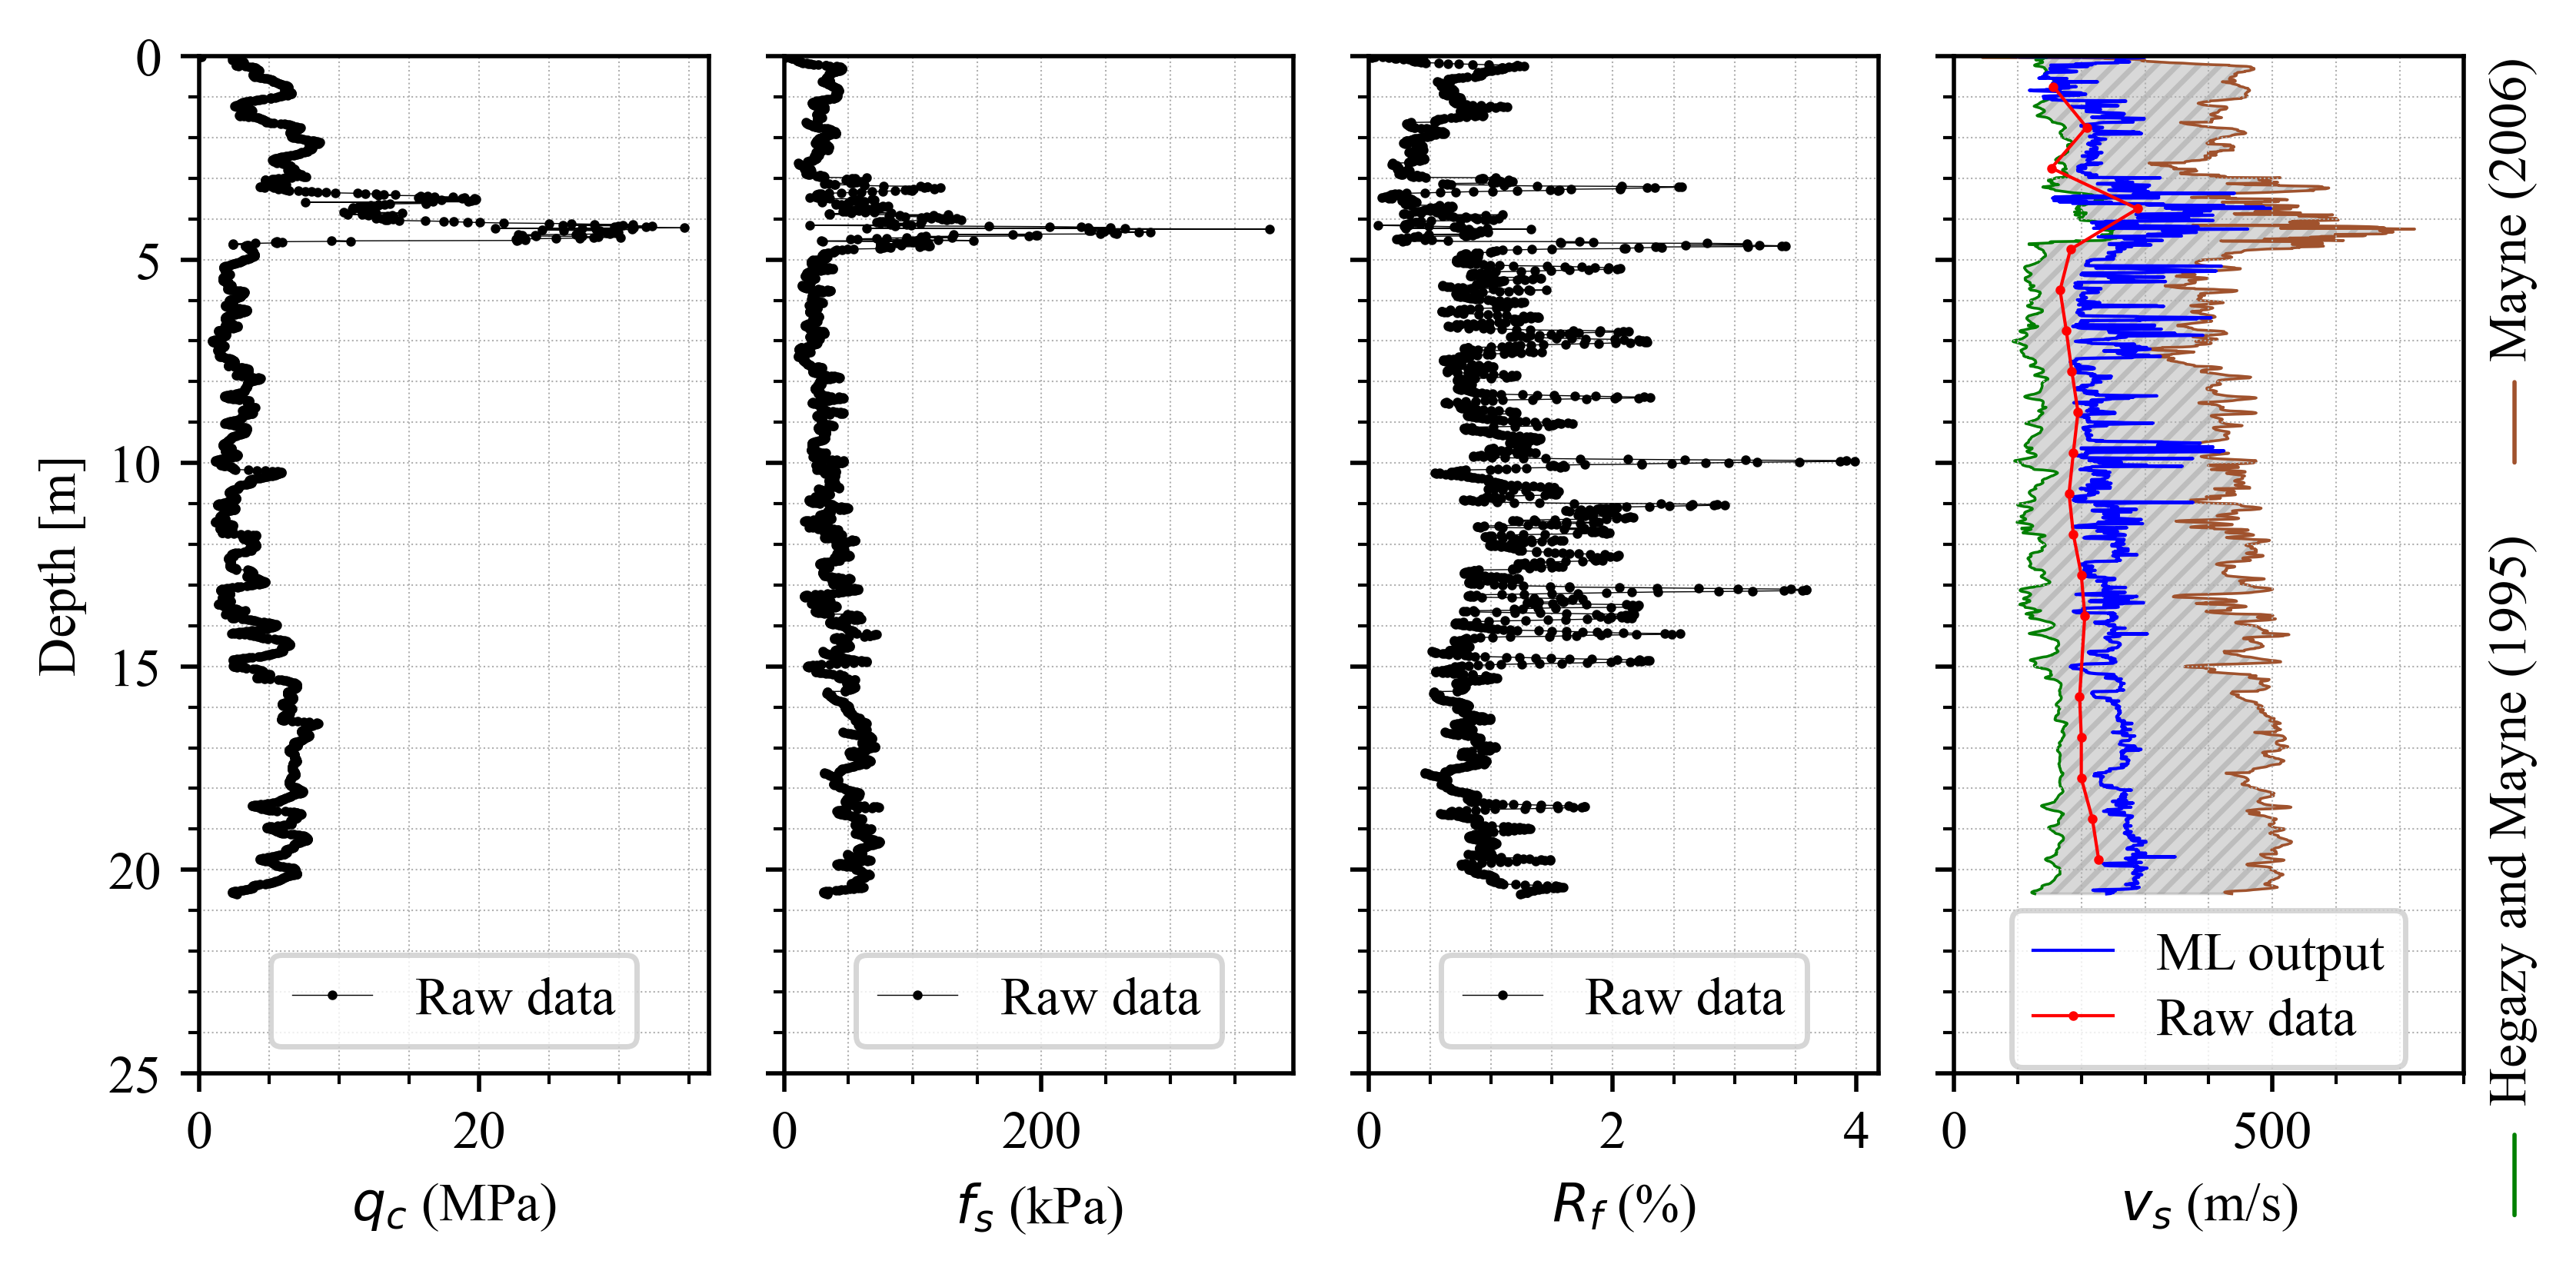

In [110]:
cm = 1/2.54  # centimeters in inches
fig, axes = plot_cpt_data_NW_site_all((17*cm, 8*cm), selected_columns_x, df_test_norwegen_raw, data_preproccesed_dropped, y_data_nor, y_pred, plot_columns_x_label)

labels = ['Mayne (2006)', 'Hegazy and Mayne (1995)']

line2 = axes[-1].plot(vs_2, z, marker='d', markevery = 1,  markeredgecolor='k', markeredgewidth=0.0, color='sienna', linewidth=0.5, markersize=0, linestyle='solid', zorder=-10) #Mayne (2006)
axes[-1].annotate('', xy=(1.1, 0.59), xytext=(1.1, 0.69), arrowprops=dict(arrowstyle='-', linestyle='solid', linewidth=0.8, color='sienna'), xycoords='axes fraction')
axes[-1].text(1.05, 0.85, labels[0], color='k', ha='left', va='center', rotation=90, transform=axes[-1].transAxes)

line3 = axes[-1].plot(vs_10, z, marker='s', markevery=1, markeredgecolor='k', markeredgewidth=0.0, color='green', linewidth=0.5, markersize=0, linestyle='solid', zorder=-10) #Hegazy and Mayne 1995
axes[-1].annotate('', xy=(1.1, -0.15), xytext=(1.1, -0.05), arrowprops=dict(arrowstyle='-', linestyle='solid', linewidth=0.8, color='green'), xycoords='axes fraction')
axes[-1].text(1.05, 0.25, labels[1], color='k', ha='left', va='center', rotation=90, transform=axes[-1].transAxes)

axes[-1].fill_betweenx(y=z, x1=vs_2, x2=vs_10, zorder=-50, facecolor='gray', alpha=0.3, hatch='//////', linewidth=0.5, edgecolor='gray')

axes[-1].set_xlim(xmin=0, xmax=800)
fig.subplots_adjust(right=0.96, top = 0.98, bottom = 0.14, left = 0.08)

plt.savefig(r"..\\graphics\C_Norwegian_test_site_XGBRegressor.png", dpi = 700)